Image modle

In [ ]:
# ===== 1. Setup and Installations =====
print("🚀 Starting environment setup...")

# Install necessary packages quietly
!pip install PyMuPDF easyocr pyzbar python-docx pycryptodome --quiet
!apt-get update && apt-get install -y libzbar0 --quiet
!python -m spacy download en_core_web_md --quiet

# Import all required libraries
import os
import re
import json
import uuid
import cv2
import spacy
import numpy as np
import easyocr
import shutil
from pyzbar.pyzbar import decode
from typing import List, Tuple
from datetime import datetime, timezone
from IPython.display import display, Image, HTML
from google.colab import files

# ===== 2. Model and Configuration Loading =====
print("\n🧠 Loading AI models...")

# Load SpaCy NLP Model for Named Entity Recognition
try:
    nlp = spacy.load("en_core_web_md")
    print("✅ SpaCy NLP model (en_core_web_md) loaded.")
except OSError:
    print("❌ Error loading SpaCy model. Please ensure the download step above was successful.")
    raise

# Load EasyOCR Model for text detection
reader = easyocr.Reader(['en'], gpu=False)
print("✅ EasyOCR model loaded.")

# Load OpenCV models for face and QR detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
qr_detector = cv2.QRCodeDetector()
print("✅ OpenCV models (Face & QR) loaded.")

# Define PII Regex Patterns for quick text scanning
PII_REGEX = {
    "EMAIL": re.compile(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"),
    "PHONE_NUMBER": re.compile(r"(\+?\d{1,3}[\s\-]?)?(\(?\d{2,4}\)?[\s\-]?)?\d{3,4}[\s\-]?\d{3,4}\b(?:\s*x\d{1,5})?"),
    "CREDIT_CARD": re.compile(r"\b(?:\d[ -]*?){13,16}\b"),
    "AADHAAR": re.compile(r"\b\d{4}\s?\d{4}\s?\d{4}\b"),
    "NAME_FULL_CAPS": re.compile(r"\b(?:[A-Z]{2,}(?:\s[A-Z]{1,}\.?){1,4})\b"),
    "ROLL_NUMBER_ID": re.compile(r"\b\d{8,}\b"), # Generic long number ID
}

print("\n🎉 Setup complete! You can now proceed to the next cells.")

🚀 Starting environment setup...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 28.6 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubunt

✅ SpaCy NLP model (en_core_web_md) loaded.
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete✅ EasyOCR model loaded.
✅ OpenCV models (Face & QR) loaded.

🎉 Setup complete! You can now proceed to the next cells.


In [ ]:
# ===== Core Image Redaction & Encryption Logic =====

from Crypto.PublicKey import ECC
# CORRECTED IMPORT STATEMENT:
from Crypto.Cipher import ChaCha20_Poly1305
from Crypto.Protocol.KDF import HKDF
from Crypto.Hash import SHA512
from Crypto.Random import get_random_bytes

# --- Global Audit Log ---
AUDIT_LOG = []

def log_event(source_file: str, pii_type: str, detected_text: str, detection_method: str, confidence: float, action: str, bbox: tuple = None):
    """Logs a detection or redaction event."""
    entry = {
        "id": f"redaction_{uuid.uuid4().hex[:8]}",
        "source_file": os.path.basename(source_file),
        "timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "pii_type": pii_type,
        "detected_text": detected_text,
        "detection_method": detection_method,
        "model_confidence": float(confidence) if confidence is not None else None,
        "action": action,
        "bounding_box": tuple(int(item) for item in bbox) if bbox is not None else None,
    }
    AUDIT_LOG.append(entry)
    with open("audit_log.jsonl", "a", encoding="utf-8") as f:
        f.write(json.dumps(entry) + "\n")

# --- Image Processing Helpers ---
def _preprocess_for_ocr(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

def _is_pii_quick_check(text: str) -> list[tuple[str, str]]:
    found_pii = []
    for key, rx in PII_REGEX.items():
        for match in rx.finditer(text):
            found_pii.append((key, match.group()))
    doc = nlp(text.title())
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "DATE"):
            found_pii.append((ent.label_, text[ent.start_char:ent.end_char]))
    return found_pii

def _detect_and_redact_qrs(img: np.ndarray, source_path: str) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    decoded_qrs = decode(gray)
    if decoded_qrs:
        for qr in decoded_qrs:
            (x, y, w, h) = qr.rect
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 0), -1)
            log_event(source_path, "QR_CODE", qr.data.decode('utf-8', 'ignore'), "pyzbar", 0.99, "REDACTED", (x, y, w, h))
    return img

# --- Main Redaction Function ---
def redact_image(input_image: np.ndarray, source_filename: str) -> np.ndarray:
    """Performs a full redaction process on a single image."""
    img = input_image.copy()

    # 1. Blur Faces
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        face_roi = img[y:y + h, x:x + w]
        blur_kernel_size = (max(1, w // 5) | 1, max(1, h // 5) | 1)
        blurred_face = cv2.GaussianBlur(face_roi, blur_kernel_size, 0)
        img[y:y + h, x:x + w] = blurred_face
        log_event(source_filename, "FACE", None, "haar_cascade", None, "BLURRED", (x, y, w, h))

    # 2. Redact Text containing PII
    ocr_results = reader.readtext(_preprocess_for_ocr(img))
    for (bbox, text_chunk, conf) in ocr_results:
        if _is_pii_quick_check(text_chunk):
            points = np.array(bbox, dtype=np.int32)
            cv2.fillPoly(img, [points], (0, 0, 0))
            log_event(source_filename, "TEXT_PII_CHUNK", text_chunk, "easyocr", conf, "REDACTED", tuple(map(int, cv2.boundingRect(points))))

    # 3. Redact QR Codes
    img = _detect_and_redact_qrs(img, source_filename)
    return img

# --- Encryption Functions ---
def generate_ecc_keys(private_key_path="private.pem", public_key_path="public.pem"):
    """Generates and saves a new ECC key pair if they don't exist."""
    if os.path.exists(private_key_path):
        print("🔑 ECC keys already exist. Skipping generation.")
        return
    print("🔑 Generating new ECC key pair (Curve: P-256)...")
    private_key = ECC.generate(curve='P-256')
    with open(private_key_path, "wt") as f:
        f.write(private_key.export_key(format='PEM'))
    with open(public_key_path, "wt") as f:
        f.write(private_key.public_key().export_key(format='PEM'))
    print(f"✅ Keys saved. KEEP '{private_key_path}' SAFE AND SECRET!")

def encrypt_log_file(log_path="audit_log.jsonl", public_key_path="public.pem", encrypted_output_path="audit_log.encrypted"):
    """Encrypts the audit log using a hybrid ECC + ChaCha20-Poly1305 scheme."""
    print(f"\n🔐 Encrypting '{log_path}'...")
    try:
        with open(public_key_path, 'rt') as f:
            recipient_key = ECC.import_key(f.read())
        with open(log_path, 'rb') as f:
            log_data = f.read()

        ephemeral_key = ECC.generate(curve='P-256')
        shared_secret = ephemeral_key.d * recipient_key.pointQ
        session_key = HKDF(shared_secret.x.to_bytes(), 32, b'', SHA512)
        cipher = ChaCha20_Poly1305.new(key=session_key)
        ciphertext, tag = cipher.encrypt_and_digest(log_data)

        encrypted_package = {
            'ephemeral_public_key': ephemeral_key.public_key().export_key(format='SEC1').hex(),
            'nonce': cipher.nonce.hex(),
            'tag': tag.hex(),
            'ciphertext': ciphertext.hex()
        }
        with open(encrypted_output_path, 'w') as f:
            json.dump(encrypted_package, f)

        print(f"✅ Successfully encrypted log to '{encrypted_output_path}'")
        os.remove(log_path)
        print(f"🗑️ Plaintext log '{log_path}' has been deleted.")
    except Exception as e:
        print(f"❌ Encryption failed: {e}")

print("✅ Redaction and Encryption functions are defined and ready.")

✅ Redaction and Encryption functions are defined and ready.


🚀 RE-DACT Image Processor with UI
Please upload one or more image files (JPG, PNG, JPEG).
📁 Cleaned and set up 'uploaded_images' for uploads and 'output_redacted_images' for results.


Saving WhatsApp Image 2025-09-22 at 15.38.32.jpeg to WhatsApp Image 2025-09-22 at 15.38.32.jpeg
Saving WhatsApp Image 2025-09-22 at 15.07.04.jpeg to WhatsApp Image 2025-09-22 at 15.07.04.jpeg

--- Starting Redaction Process for 2 images ---

Processing: WhatsApp Image 2025-09-22 at 15.38.32.jpeg


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Saved redacted image to 'output_redacted_images/redacted_WhatsApp Image 2025-09-22 at 15.38.32.jpeg'


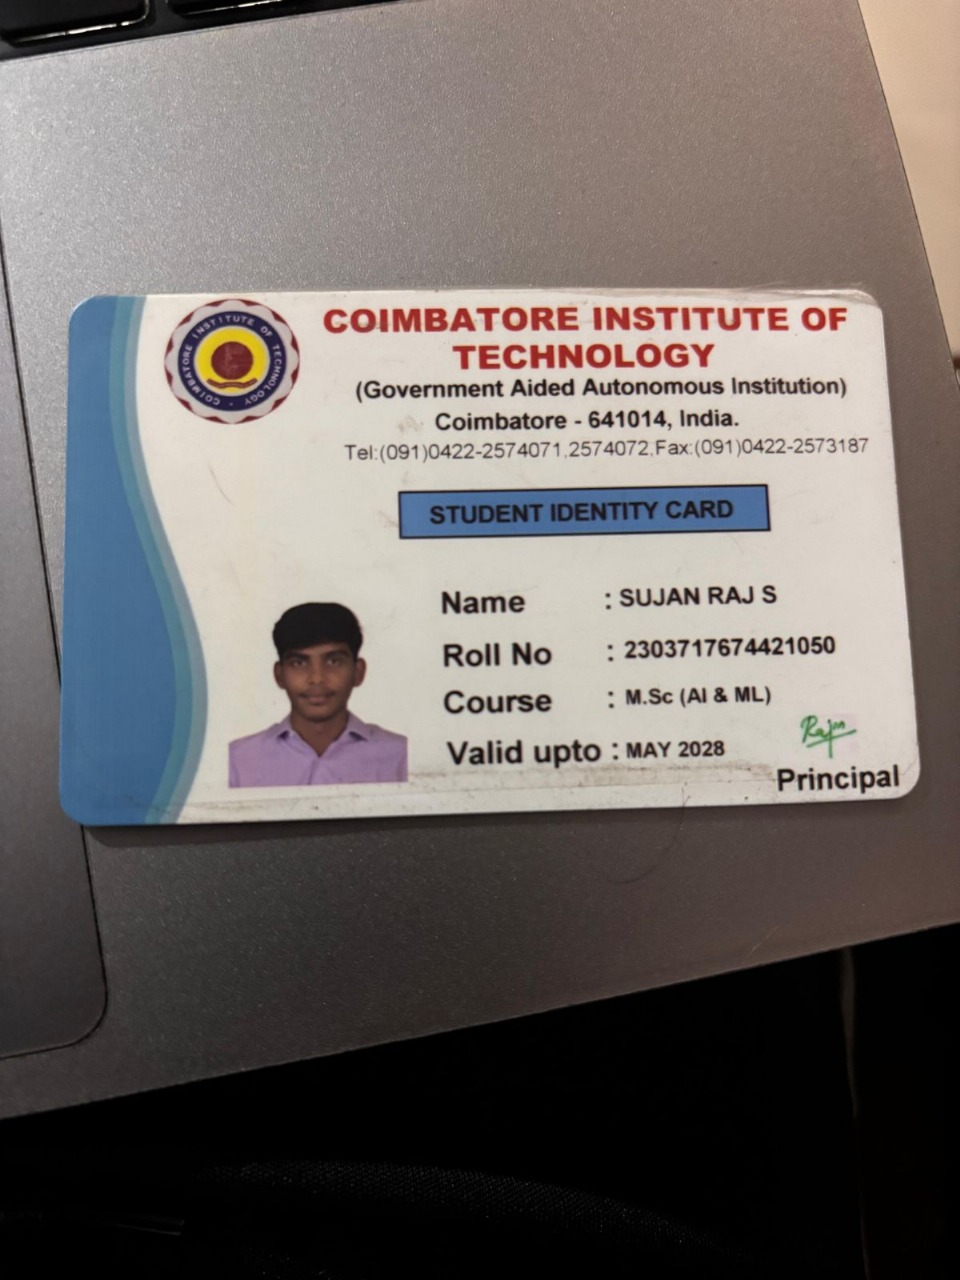

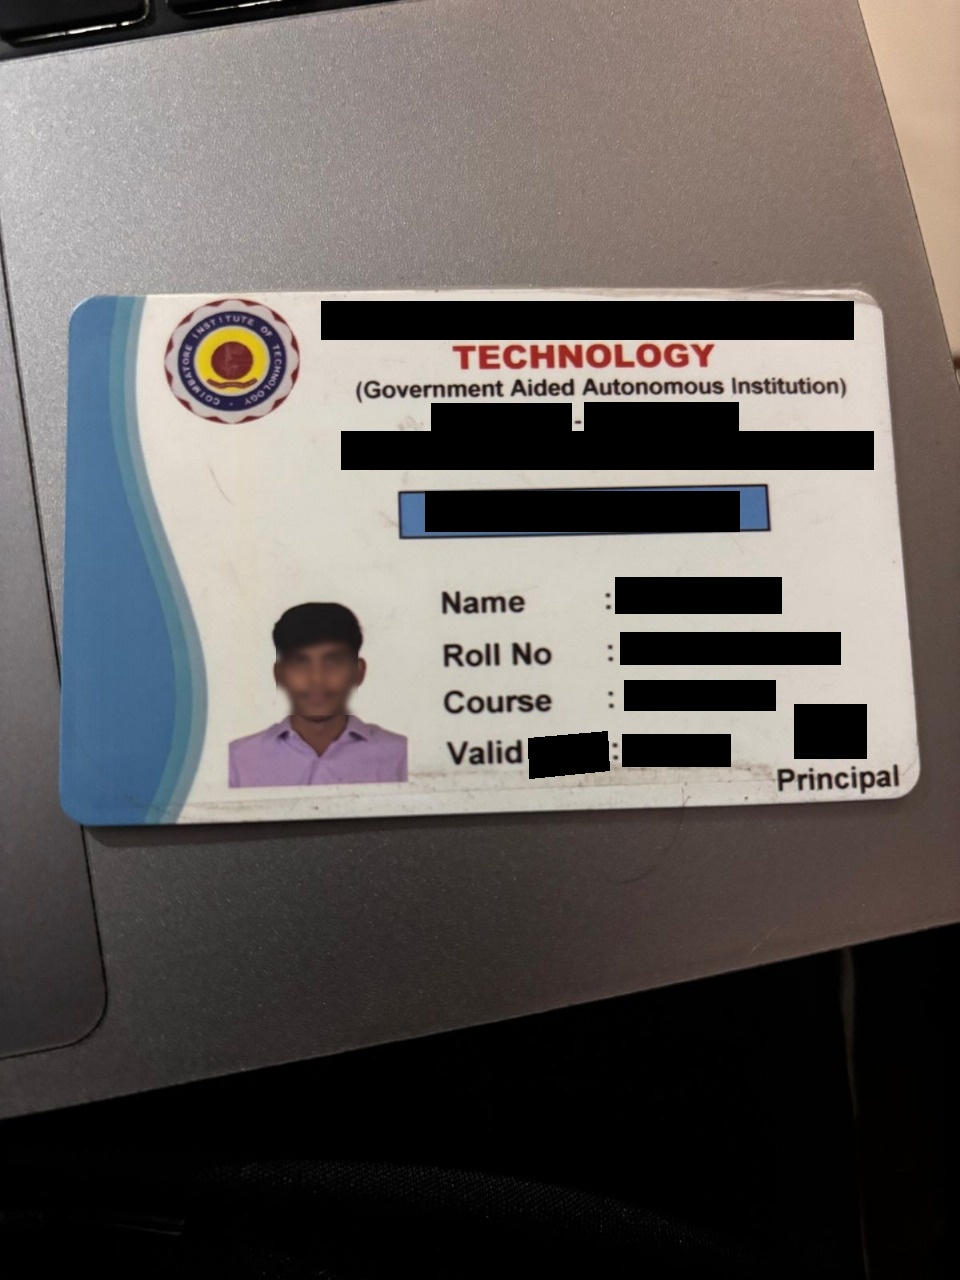


Processing: WhatsApp Image 2025-09-22 at 15.07.04.jpeg
✅ Saved redacted image to 'output_redacted_images/redacted_WhatsApp Image 2025-09-22 at 15.07.04.jpeg'


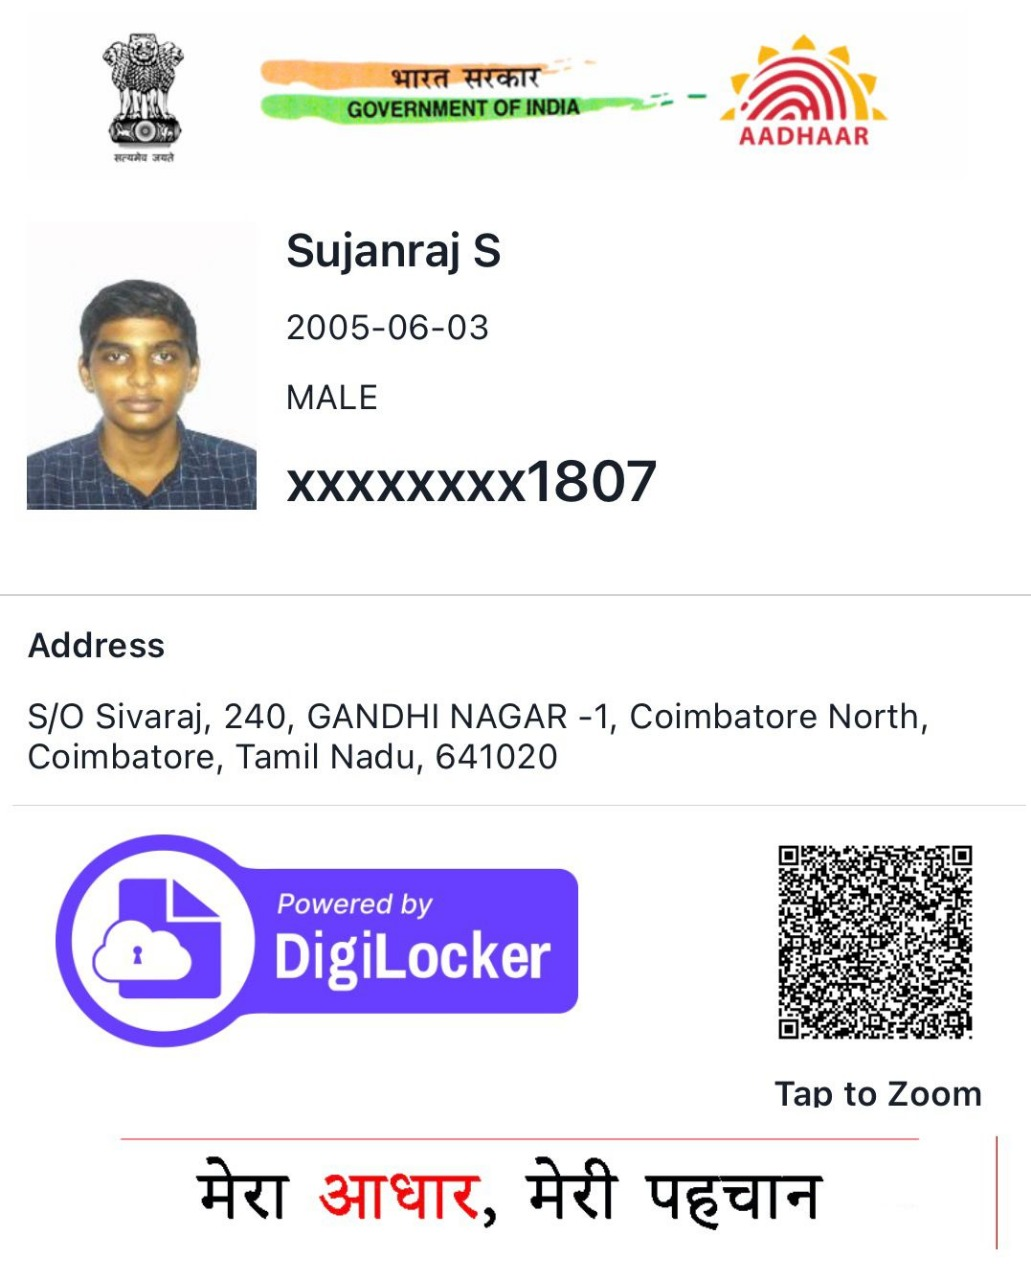

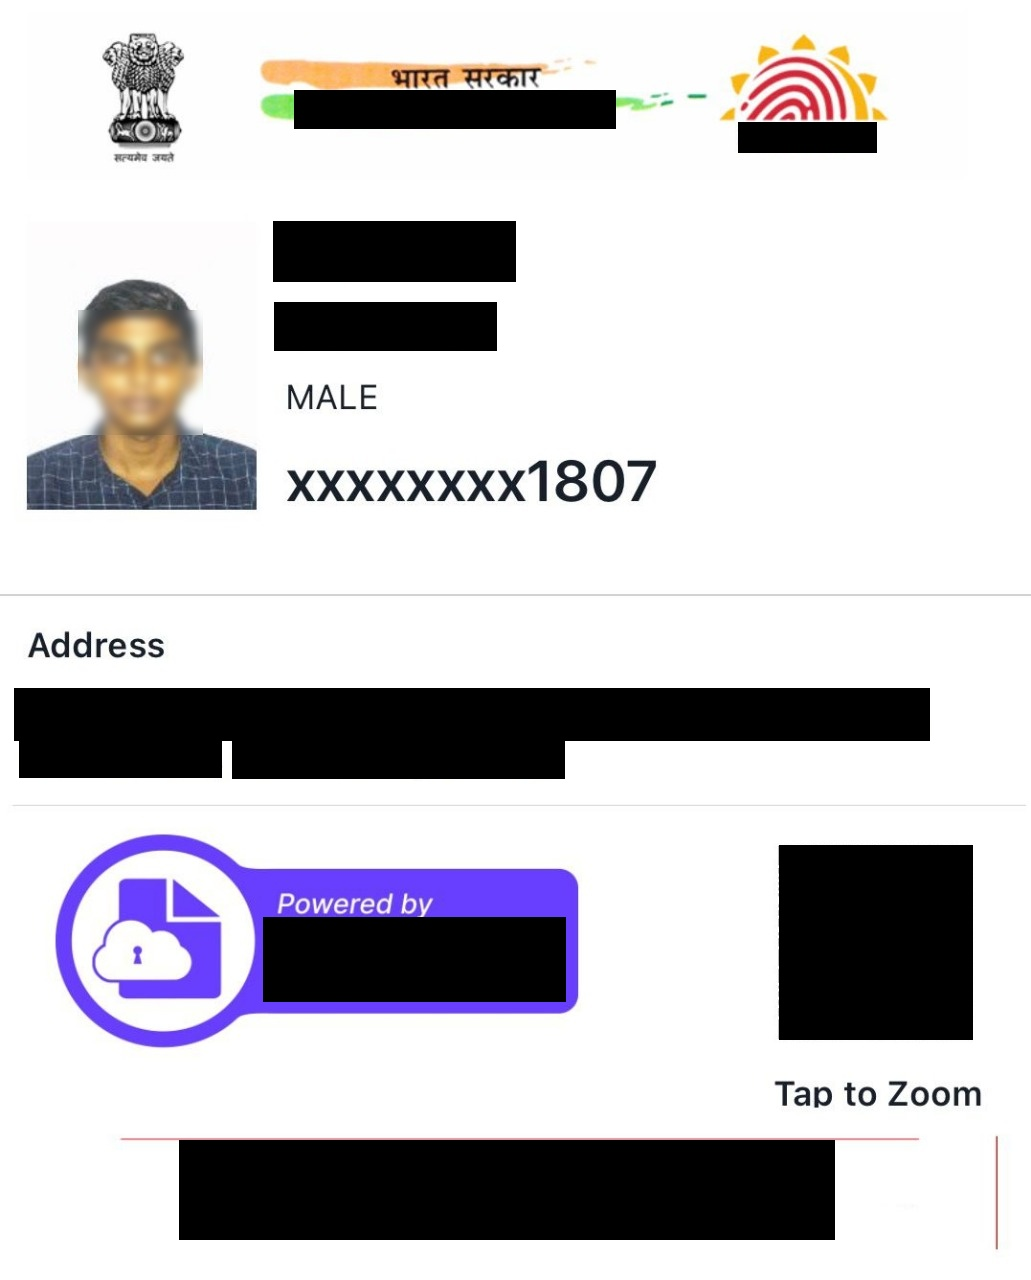


--- Finalizing Run ---
🔑 Generating new ECC key pair (Curve: P-256)...
✅ Keys saved. KEEP 'private.pem' SAFE AND SECRET!

🔐 Encrypting 'audit_log.jsonl'...
✅ Successfully encrypted log to 'audit_log.encrypted'
🗑️ Plaintext log 'audit_log.jsonl' has been deleted.


🎉 --- All Tasks Complete! --- 🎉
Redacted images are in the 'output_redacted_images' folder.
The SECURE, ENCRYPTED audit log is 'audit_log.encrypted'.
Download 'audit_log.encrypted' and your 'private.pem' file to decrypt it later.


In [ ]:
# ===== 3. Image Processing Runner with Colab UI =====

# --- Configuration ---
INPUT_DIR = "uploaded_images"
OUTPUT_DIR = "output_redacted_images"
AUDIT_LOG_FILE = "audit_log.jsonl"

def setup_directories():
    """Cleans and creates fresh directories for a new run."""
    shutil.rmtree(INPUT_DIR, ignore_errors=True)
    shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
    os.makedirs(INPUT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    if os.path.exists(AUDIT_LOG_FILE):
        os.remove(AUDIT_LOG_FILE)
    print(f"📁 Cleaned and set up '{INPUT_DIR}' for uploads and '{OUTPUT_DIR}' for results.")

def run_image_redaction_ui():
    """Main function to handle file upload, processing, display, and logging."""
    print("🚀 RE-DACT Image Processor with UI")
    print("Please upload one or more image files (JPG, PNG, JPEG).")

    setup_directories()
    uploaded_files = files.upload()

    if not uploaded_files:
        print("\nNo files uploaded. Please run the cell again.")
        return

    print(f"\n--- Starting Redaction Process for {len(uploaded_files)} images ---")

    for filename, content in uploaded_files.items():
        try:
            print(f"\nProcessing: {filename}")
            input_path = os.path.join(INPUT_DIR, filename)
            output_path = os.path.join(OUTPUT_DIR, f"redacted_{filename}")

            with open(input_path, 'wb') as f:
                f.write(content)

            original_image_np = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)
            if original_image_np is None:
                print(f"⚠️ Could not decode image file: {filename}. Skipping.")
                continue

            redacted_image_np = redact_image(original_image_np, filename)
            cv2.imwrite(output_path, redacted_image_np)
            print(f"✅ Saved redacted image to '{output_path}'")

            # Display results in the output area
            display(HTML(f"<hr><h3>Original: {filename}</h3>"))
            display(Image(filename=input_path, width=400))
            display(HTML(f"<h3>Redacted: redacted_{filename}</h3>"))
            display(Image(filename=output_path, width=400))

        except Exception as e:
            print(f"❌ An error occurred while processing {filename}: {e}")

    # --- Finalize and Encrypt Log ---
    print("\n--- Finalizing Run ---")
    generate_ecc_keys()
    if os.path.exists(AUDIT_LOG_FILE) and os.path.getsize(AUDIT_LOG_FILE) > 0:
        encrypt_log_file(log_path=AUDIT_LOG_FILE)
    else:
        print("ℹ️ Audit log is empty or does not exist. Skipping encryption.")

    print("\n\n🎉 --- All Tasks Complete! --- 🎉")
    print(f"Redacted images are in the '{OUTPUT_DIR}' folder.")
    print("The SECURE, ENCRYPTED audit log is 'audit_log.encrypted'.")
    print("Download 'audit_log.encrypted' and your 'private.pem' file to decrypt it later.")

# --- Run the application ---
run_image_redaction_ui()

Document model

In [ ]:
!pip install easyocr pymupdf

In [ ]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# ===== RE-DACT Hybrid Toolkit (Combined & Enhanced Version) =====
# This script merges the excellent DOCX handling from the old code with the
# superior image, QR, and PDF processing from the new code.

# -------- 1. Setup and Installations --------

# Install necessary packages if they are not already installed
try:
    import fitz  # PyMuPDF
except ImportError:
    print("Installing PyMuPDF for PDF handling...")
    !pip install PyMuPDF --quiet
    import fitz

try:
    import easyocr
except ImportError:
    print("Installing EasyOCR for text recognition...")
    !pip install easyocr --quiet
    import easyocr

try:
    from pyzbar.pyzbar import decode
except ImportError:
    print("Installing pyzbar for QR Code detection...")
    !apt-get update && apt-get install -y libzbar0
    !pip install pyzbar --quiet
    from pyzbar.pyzbar import decode

try:
    import docx
except ImportError:
    print("Installing python-docx...")
    !pip install python-docx --quiet
    import docx

import os, re, json, uuid, io
from datetime import datetime, timezone
from google.colab import files
import numpy as np
import cv2
import spacy
from typing import List, Dict, Tuple

# -------- 2. Model Loading --------

# Load NLP Model (using a reliable medium-sized model)
print("Loading NLP model (en_core_web_md)...")
try:
    nlp = spacy.load("en_core_web_md")
    print("✅ Using en_core_web_md.")
except OSError:
    print("⚠ 'en_core_web_md' not found. Downloading...")
    !python -m spacy download en_core_web_md --quiet
    nlp = spacy.load("en_core_web_md")
    print("✅ Model 'en_core_web_md' downloaded and loaded.")

# Load OCR, Face, and QR Detection Models
print("Loading OCR and Computer Vision models...")
reader = easyocr.Reader(['en'], gpu=False)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
qr_detector = cv2.QRCodeDetector()
print("✅ Models loaded successfully.")


# -------- 3. Audit Logging --------
# Using the corrected version that prevents JSON serialization errors with NumPy types.

AUDIT_LOG = []
def log_event(source_file, pii_type, detected_text, detection_method, confidence, action, bbox=None):
    """Logs a detection or redaction event."""
    if bbox is not None:
        # CORRECTED: Explicitly cast each item to a standard Python int
        bbox = tuple(int(item) for item in bbox)

    entry = {
        "id": f"redaction_{uuid.uuid4().hex[:8]}",
        "source_file": os.path.basename(source_file),
        "timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "pii_type": pii_type,
        "detected_text": detected_text,
        "detection_method": detection_method,
        "model_confidence": float(confidence) if confidence is not None else None,
        "action": action,
        "bounding_box": bbox
    }
    AUDIT_LOG.append(entry)
    with open("audit_log.jsonl", "a", encoding="utf-8") as f:
        f.write(json.dumps(entry) + "\n")


# -------- 4. PII Detection Logic --------

# MERGED: Combined regex patterns from both scripts for maximum coverage.
PII_REGEX = {
    "EMAIL": re.compile(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"),
    "PHONE_NUMBER": re.compile(r"(\+?\d{1,3}[\s\-]?)?(\(?\d{2,4}\)?[\s\-]?)?\d{3,4}[\s\-]?\d{3,4}\b(?:\s*x\d{1,5})?"),
    "CREDIT_CARD": re.compile(r"\b(?:\d[ -]*?){13,16}\b"),
    "AADHAAR": re.compile(r"\b\d{4}\s?\d{4}\s?\d{4}\b"),
    "NAME_FULL_CAPS": re.compile(r"\b(?:[A-Z]{2,}(?:\s[A-Z]{1,}\.?){1,4})\b"),
    "ROLL_NUMBER_ID": re.compile(r"\b\d{8,}\b"), # Generic long number ID
}

def is_pii_quick_check(text: str) -> List[Tuple[str, str]]:
    """
    A fast check used by the image processor to see IF a text chunk contains PII.
    Returns a list of tuples (pii_type, matched_text).
    """
    found_pii = []
    # 1. Regex-based detection
    for key, rx in PII_REGEX.items():
        if rx.search(text):
            for match in rx.finditer(text):
                found_pii.append((key, match.group()))

    # 2. NLP-based detection (case-insensitivity handled by .title())
    doc = nlp(text.title())
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "DATE"):
            original_text_slice = text[ent.start_char:ent.end_char]
            found_pii.append((ent.label_, original_text_slice))
    return found_pii

def find_pii_spans_for_text(text: str) -> List[Dict]:
    """
    Finds PII and returns detailed spans (start/end indices).
    This is used for redacting text in DOCX files.
    """
    spans = []
    # Regex-based detection
    for key, rx in PII_REGEX.items():
        for m in rx.finditer(text):
            spans.append({"type": key, "start": m.start(), "end": m.end(), "text": m.group(), "method": "regex", "confidence": 0.95})
    # NLP-based detection
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "DATE"):
            spans.append({"type": ent.label_, "start": ent.start_char, "end": ent.end_char, "text": ent.text, "method": "spacy", "confidence": None})
    return spans

def redact_substring(text: str, spans: List[Dict], redaction_char="█"):
    """Redacts portions of a string based on a list of PII spans."""
    spans.sort(key=lambda x: x['start'], reverse=True)
    for s in spans:
        length = s['end'] - s['start']
        text = text[:s['start']] + (redaction_char * length) + text[s['end']:]
    return text


# -------- 5. Advanced Image Redaction Engine (From New Code) --------

def preprocess_for_ocr(img: np.ndarray) -> np.ndarray:
    """Applies preprocessing to an image to improve OCR accuracy."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
    return processed_img

def detect_and_redact_qrs(img: np.ndarray, source_path: str) -> np.ndarray:
    """Detects and redacts QR codes using a primary and fallback method."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Primary method: pyzbar
    decoded_qrs = decode(gray)
    if decoded_qrs:
        for qr in decoded_qrs:
            (x, y, w, h) = qr.rect
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 0), -1)
            log_event(source_path, "QR_CODE", qr.data.decode('utf-8', 'ignore'), "pyzbar", 0.99, "REDACTED", (x, y, w, h))
        return img
    # Fallback method: OpenCV
    data, bbox, _ = qr_detector.detectAndDecode(gray)
    if bbox is not None and data:
        points = bbox[0].astype(int)
        cv2.fillPoly(img, [points], (0, 0, 0))
        (x, y, w, h) = cv2.boundingRect(points)
        log_event(source_path, "QR_CODE", data, "opencv_qr", 0.95, "REDACTED", (x, y, w, h))
    return img

def redact_image_content(img: np.ndarray, source_path: str) -> np.ndarray:
    """Performs all redaction operations on a single image array."""
    # 1. Blur faces
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        roi = img[y:y + h, x:x + w]
        blur_kernel_size = (max(1, w // 5) | 1, max(1, h // 5) | 1)
        roi = cv2.GaussianBlur(roi, blur_kernel_size, 0)
        img[y:y + h, x:x + w] = roi
        log_event(source_path, "FACE", None, "haar_cascade", None, "BLURRED", (x, y, w, h))

    # 2. Blackout text with PII
    preprocessed_img = preprocess_for_ocr(img)
    ocr_results = reader.readtext(preprocessed_img)
    for (bbox, text_chunk, conf) in ocr_results:
        found_pii_in_chunk = is_pii_quick_check(text_chunk)
        if found_pii_in_chunk:
            for pii_type, pii_text in found_pii_in_chunk:
                log_event(source_path, pii_type, pii_text, "easyocr+logic", conf, "DETECTED")
            points = np.array(bbox, dtype=np.int32)
            cv2.fillPoly(img, [points], (0,0,0))
            log_event(source_path, "TEXT_PII_CHUNK", text_chunk, "easyocr", conf, "REDACTED", tuple(map(int, cv2.boundingRect(points))))

    # 3. Blackout QR Codes
    img = detect_and_redact_qrs(img, source_path)
    return img


# -------- 6. Top-Level Redaction Functions --------

def redact_image_file(path: str, out_path: str):
    """Redacts PII from a standalone image file."""
    print(f"Processing Image: {os.path.basename(path)}...")
    img = cv2.imread(path)
    if img is None:
        print(f"⚠ Could not read image file: {path}")
        return
    redacted_img = redact_image_content(img, path)
    cv2.imwrite(out_path, redacted_img)
    print(f"✅ Saved redacted image: {out_path}")

def redact_pdf(path: str, out_path: str):
    """Redacts PII from both text-based and image-based PDFs."""
    print(f"Processing PDF: {os.path.basename(path)}...")
    pdf_doc = fitz.open(path)
    for page_num, page in enumerate(pdf_doc):
        print(f"  - Page {page_num + 1}: Performing image-based redaction...")
        # Always treat the page as an image to catch everything.
        pix = page.get_pixmap(dpi=200) # Use 200 DPI for a good balance of speed and accuracy
        img_bytes = pix.tobytes("png")
        np_arr = np.frombuffer(img_bytes, np.uint8)
        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

        # Use the powerful image redaction engine
        redacted_img = redact_image_content(img.copy(), path)

        # Overlay the redacted image back onto the page
        _, buffer = cv2.imencode('.png', redacted_img)
        page.insert_image(page.rect, stream=buffer.tobytes())

        # Additionally, redact any selectable text layers underneath
        text = page.get_text("text")
        if text.strip():
            pii_spans = find_pii_spans_for_text(text)
            for span in pii_spans:
                areas = page.search_for(span['text'])
                for inst in areas:
                    page.add_redact_annot(inst, fill=(0, 0, 0))
                    log_event(path, span['type'], span['text'], "fitz_text_search", 1.0, "REDACTED_TEXT_LAYER", (inst.x0, inst.y0, inst.width, inst.height))
            page.apply_redactions()

    pdf_doc.save(out_path, garbage=4, deflate=True)
    print(f"✅ Saved redacted PDF: {out_path}")

def redact_docx(path: str, out_path: str):
    """Redacts PII from a .docx file, including text and embedded images."""
    print(f"Processing DOCX: {os.path.basename(path)}...")
    source_doc = docx.Document(path)
    new_doc = docx.Document()

    # 1. Process and redact text content
    print("  - Redacting text...")
    for p in source_doc.paragraphs:
        if not p.text or not p.text.strip():
            new_doc.add_paragraph("")
            continue
        pii_spans = find_pii_spans_for_text(p.text)
        for span in pii_spans:
            log_event(path, span['type'], span['text'], span['method'], span.get('confidence'), "DETECTED")
        redacted_text = redact_substring(p.text, pii_spans)
        new_doc.add_paragraph(redacted_text)

    # 2. Process and redact images
    print("  - Redacting embedded images...")
    image_rels = [rel for rel in source_doc.part.rels.values() if "image" in rel.target_ref]
    for rel in image_rels:
        image_part = rel.target_part
        image_bytes = image_part.blob
        np_arr = np.frombuffer(image_bytes, np.uint8)
        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

        # ENHANCEMENT: Use the same powerful image redaction engine here
        if img is not None:
            redacted_img = redact_image_content(img, path)
            _, buffer = cv2.imencode('.png', redacted_img)
            image_stream = io.BytesIO(buffer)
            new_doc.add_picture(image_stream)

    new_doc.save(out_path)
    print(f"✅ Saved redacted DOCX: {out_path}")


# -------- 7. Main Execution Menu --------

def run_menu():
    """Main function to run the Colab file upload and processing menu."""
    print("\n🚀 RE-DACT: AI-Powered Redaction Toolkit (Hybrid Version)")
    print("Please upload one or more files (JPG, PNG, PDF, DOCX).")
    try:
        # Clear previous audit log
        if os.path.exists("audit_log.jsonl"):
            os.remove("audit_log.jsonl")

        uploaded = files.upload()
        if not uploaded:
            print("No files were uploaded. Please run the cell again.")
            return

        print("\n--- Starting Redaction Process ---")
        for fname in uploaded.keys():
            print(f"\nProcessing: {fname}")
            base_name, ext = os.path.splitext(os.path.basename(fname))
            ext = ext.lower()
            out_path = f"redacted_{base_name}{ext}"

            if ext in ['.jpg', '.jpeg', '.png']:
                redact_image_file(fname, out_path)
            elif ext == '.pdf':
                redact_pdf(fname, out_path)
            elif ext == '.docx':
                redact_docx(fname, out_path)
            else:
                print(f"⚠ Unsupported file type: {ext}. Skipping.")

        print("\n--- Redaction Process Complete ---")
        print("You can download the redacted files and the 'audit_log.jsonl' from the file browser on the left.")

    except Exception as e:
        import traceback
        print(f"\nAn unexpected error occurred: {e}")
        traceback.print_exc()

# 🚀 Run the redaction tool
run_menu()

Loading NLP model (en_core_web_md)...


✅ Using en_core_web_md.
Loading OCR and Computer Vision models...
✅ Models loaded successfully.

🚀 RE-DACT: AI-Powered Redaction Toolkit (Hybrid Version)
Please upload one or more files (JPG, PNG, PDF, DOCX).


Saving DocScanner 24-Feb-2025 11-12 PM.pdf to DocScanner 24-Feb-2025 11-12 PM.pdf

--- Starting Redaction Process ---

Processing: DocScanner 24-Feb-2025 11-12 PM.pdf
Processing PDF: DocScanner 24-Feb-2025 11-12 PM.pdf...
  - Page 1: Performing image-based redaction...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Saved redacted PDF: redacted_DocScanner 24-Feb-2025 11-12 PM.pdf

--- Redaction Process Complete ---
You can download the redacted files and the 'audit_log.jsonl' from the file browser on the left.


Encrypted AUDIT_log

In [ ]:
# ===== RE-DACT Hybrid Toolkit (Final Secure Version with Encryption) =====
# This version encrypts the audit log for confidentiality and integrity.

# Install necessary packages
!pip install PyMuPDF easyocr pyzbar cryptography --quiet
print("✅ Required packages installed.")

import fitz  # PyMuPDF
import easyocr
from pyzbar.pyzbar import decode
from cryptography.fernet import Fernet

import os, re, json, uuid, io
from datetime import datetime, timezone
from google.colab import files
import numpy as np
import cv2
import spacy
from typing import List, Dict, Tuple

# -------- Safe NLP Loader (Using en_core_web_md) --------
print("Loading NLP model (en_core_web_md)...")
try:
    nlp = spacy.load("en_core_web_md")
    print("✅ Using en_core_web_md.")
except OSError:
    print("⚠️ 'en_core_web_md' not found. Downloading...")
    !python -m spacy download en_core_web_md --quiet
    nlp = spacy.load("en_core_web_md")
    print("✅ Model 'en_core_web_md' downloaded and loaded.")

# -------- OCR, Face, and QR Detection Setup --------
print("Loading OCR and Computer Vision models...")
reader = easyocr.Reader(['en'], gpu=False)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
qr_detector = cv2.QRCodeDetector()
print("✅ Models loaded successfully.")


# -------- ENCRYPTION SETUP --------
print("Setting up encryption for audit log...")
KEY_FILE = "secret.key"

def generate_key():
    """Generates a new key and saves it to the key file."""
    key = Fernet.generate_key()
    with open(KEY_FILE, "wb") as key_file:
        key_file.write(key)
    return key

def load_key():
    """Loads the key from the key file or generates a new one."""
    if not os.path.exists(KEY_FILE):
        print(f"Key file not found. Generating a new one at '{KEY_FILE}'.")
        print("IMPORTANT: Keep this key file safe to decrypt your logs!")
        return generate_key()
    with open(KEY_FILE, "rb") as key_file:
        return key_file.read()

# Load the encryption key and initialize Fernet
encryption_key = load_key()
fernet = Fernet(encryption_key)
print("✅ Encryption setup complete.")


# -------- Audit Log (NOW ENCRYPTED) --------
AUDIT_LOG = []
LOG_FILE = "audit_log.jsonl.encrypted"

def log_event(source_file, pii_type, detected_text, detection_method, confidence, action, bbox=None):
    """Creates a log entry, encrypts it, and appends it to the secure log file."""
    if bbox is not None:
        bbox = tuple(int(item) for item in bbox)

    entry = {
        "id": f"redaction_{uuid.uuid4().hex[:8]}",
        "source_file": os.path.basename(source_file),
        "timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "pii_type": pii_type,
        "detected_text": detected_text,
        "detection_method": detection_method,
        "model_confidence": float(confidence) if confidence is not None else None,
        "action": action,
        "bounding_box": bbox
    }
    AUDIT_LOG.append(entry)

    # Convert entry to JSON string, encode to bytes, then encrypt
    log_string = json.dumps(entry)
    encrypted_log = fernet.encrypt(log_string.encode('utf-8'))

    with open(LOG_FILE, "ab") as f: # Append bytes
        f.write(encrypted_log + b"\n")


# -------- Regex and PII Logic (Unchanged) --------
PII_REGEX = {
    "EMAIL": re.compile(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"),
    "PHONE_NUMBER_FULL": re.compile(r"(\+?\d{1,3}[\s\-]?)?(\(?\d{2,4}\)?[\s\-]?)?\d{3,4}[\s\-]?\d{3,4}\b(?:\s*x\d{1,5})?"),
    "AADHAAR": re.compile(r"\b\d{4}\s?\d{4}\s?\d{4}\b"),
    "NAME_FULL_CAPS": re.compile(r"\b(?:[A-Z]{2,}(?:\s[A-Z]{1,}\.?){1,4})\b"),
    "ROLL_NUMBER": re.compile(r"\b\d{10,}\b"),
}

def is_pii(text: str) -> List[Tuple[str, str]]:
    found_pii = []
    for key, rx in PII_REGEX.items():
        if rx.search(text):
            for match in rx.finditer(text):
                found_pii.append((key, match.group()))
    doc = nlp(text.title())
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "ORG", "GPE", "LOC", "DATE"):
            original_text_slice = text[ent.start_char:ent.end_char]
            found_pii.append((ent.label_, original_text_slice))
    return found_pii

# -------- Image Redaction Logic (Unchanged) --------
def preprocess_for_ocr(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

def detect_and_redact_qrs(img: np.ndarray, source_path: str) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    decoded_qrs = decode(gray)
    if decoded_qrs:
        for qr in decoded_qrs:
            (x, y, w, h) = qr.rect
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 0), -1)
            log_event(source_path, "QR_CODE", qr.data.decode('utf-8', 'ignore'), "pyzbar", 0.99, "REDACTED", (x, y, w, h))
        return img
    data, bbox, _ = qr_detector.detectAndDecode(gray)
    if bbox is not None and data:
        points = bbox[0].astype(int)
        cv2.fillPoly(img, [points], (0, 0, 0))
        (x, y, w, h) = cv2.boundingRect(points)
        log_event(source_path, "QR_CODE", data, "opencv_qr", 0.95, "REDACTED", (x, y, w, h))
    return img

def redact_image_content(img: np.ndarray, source_path: str) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        roi = img[y:y + h, x:x + w]
        blur_kernel_size = (max(1, w // 5) | 1, max(1, h // 5) | 1)
        roi = cv2.GaussianBlur(roi, blur_kernel_size, 0)
        img[y:y + h, x:x + w] = roi
        log_event(source_path, "FACE", None, "haar_cascade", None, "BLURRED", (x, y, w, h))

    preprocessed_img = preprocess_for_ocr(img)
    ocr_results = reader.readtext(preprocessed_img)
    for (bbox, text_chunk, conf) in ocr_results:
        found_pii_in_chunk = is_pii(text_chunk)
        if found_pii_in_chunk:
            for pii_type, pii_text in found_pii_in_chunk:
                log_event(source_path, pii_type, pii_text, "easyocr+logic", conf, "DETECTED")
            points = np.array(bbox, dtype=np.int32)
            cv2.fillPoly(img, [points], (0, 0, 0))
            log_event(source_path, "TEXT_PII_CHUNK", text_chunk, "easyocr", conf, "REDACTED", tuple(map(int, cv2.boundingRect(points))))
    return detect_and_redact_qrs(img, source_path)

# -------- Top-Level Redaction and Main Menu --------
def redact_image_file(path: str, out_path: str):
    img = cv2.imread(path)
    if img is None:
        print(f"⚠️ Could not read image file: {path}")
        return
    redacted_img = redact_image_content(img, path)
    cv2.imwrite(out_path, redacted_img)
    print(f"✅ Saved redacted image: {out_path}")

def run_menu():
    """Main function to run the Colab file upload and processing menu."""
    print("\n🚀 RE-DACT: Secure Redaction Toolkit")
    print("This tool redacts PII and generates a secure, encrypted audit log.")
    try:
        # Clear previous encrypted log
        if os.path.exists(LOG_FILE):
            os.remove(LOG_FILE)

        uploaded = files.upload()
        if not uploaded:
            print("No files were uploaded. Please run the cell again.")
            return

        print("\n--- Starting Redaction Process ---")
        for fname in uploaded.keys():
            print(f"\nProcessing: {fname}")
            base_name, ext = os.path.splitext(os.path.basename(fname))
            out_path = f"redacted_{base_name}{ext}"
            redact_image_file(fname, out_path)

        print("\n--- Redaction Process Complete ---")
        print(f"You can download the redacted files, the encrypted log '{LOG_FILE}', and the all-important '{KEY_FILE}'.")
        print("⚠️ WARNING: Do not lose the 'secret.key' file! It is required to read the audit log.")

    except Exception as e:
        import traceback
        print(f"\nAn unexpected error occurred: {e}")
        traceback.print_exc()

# -------- HELPER FUNCTION TO DECRYPT AND READ THE LOG --------
def read_and_decrypt_log():
    """A helper function to demonstrate how to read the encrypted log."""
    try:
        key = load_key()
        f = Fernet(key)
        print(f"\n--- Decrypted Audit Log from '{LOG_FILE}' ---")
        with open(LOG_FILE, "rb") as log_file:
            for line in log_file:
                if not line.strip():
                    continue
                decrypted_line = f.decrypt(line)
                log_entry = json.loads(decrypted_line.decode('utf-8'))
                print(json.dumps(log_entry, indent=2))
        print("--- End of Log ---")
    except FileNotFoundError:
        print(f"Log file '{LOG_FILE}' not found. Run the redaction tool first.")
    except Exception as e:
        print(f"An error occurred while decrypting the log: {e}")
        print("Ensure you are using the correct 'secret.key' file.")


# 🚀 Run the redaction tool
run_menu()

# 🔍 To read your secure log, run the next cell with the read_and_decrypt_log() function.

✅ Required packages installed.
Loading NLP model (en_core_web_md)...


✅ Using en_core_web_md.
Loading OCR and Computer Vision models...
✅ Models loaded successfully.
Setting up encryption for audit log...
Key file not found. Generating a new one at 'secret.key'.
IMPORTANT: Keep this key file safe to decrypt your logs!
✅ Encryption setup complete.

🚀 RE-DACT: Secure Redaction Toolkit
This tool redacts PII and generates a secure, encrypted audit log.


Saving redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg to redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg

--- Starting Redaction Process ---

Processing: redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg
✅ Saved redacted image: redacted_redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg

--- Redaction Process Complete ---
You can download the redacted files, the encrypted log 'audit_log.jsonl.encrypted', and the all-important 'secret.key'.
⚠️ WARNING: Do not lose the 'secret.key' file! It is required to read the audit log.


In [ ]:
read_and_decrypt_log()


--- Decrypted Audit Log from 'audit_log.jsonl.encrypted' ---
{
  "id": "redaction_ed5fa320",
  "source_file": "redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg",
  "timestamp_utc": "2025-09-22T16:25:26.546594+00:00",
  "pii_type": "FACE",
  "detected_text": null,
  "detection_method": "haar_cascade",
  "model_confidence": null,
  "action": "BLURRED",
  "bounding_box": [
    468,
    33,
    142,
    142
  ]
}
{
  "id": "redaction_b4d7971a",
  "source_file": "redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg",
  "timestamp_utc": "2025-09-22T16:25:26.556379+00:00",
  "pii_type": "FACE",
  "detected_text": null,
  "detection_method": "haar_cascade",
  "model_confidence": null,
  "action": "BLURRED",
  "bounding_box": [
    916,
    84,
    135,
    135
  ]
}
{
  "id": "redaction_47d4971c",
  "source_file": "redacted_WhatsApp Image 2025-09-22 at 15.47.58.jpeg",
  "timestamp_utc": "2025-09-22T16:25:26.559489+00:00",
  "pii_type": "FACE",
  "detected_text": null,
  "detection_method": 

In [ ]:
!head -n 5 audit_log.jsonl.encrypted

gAAAAABo0Xh2EBUuuU-awU6qZHB0QWLQpvFo7_IiFmz4n_tQL6mYegUF3HA2Rf6RHLYgc-aCZUQZF0ZeIR_5NkIkOSiZjOy7hSvsUX8x-Ml-lKQ7TYbCS_jmwH7I6ajauCFzWnLZKRfRPsqIL0BUoK9wE4THoLqNYkOk8xXucDepjP6sIM4kZGuXhi4fLXnL42nKFNUqw_N2S0PvKkxhZhjW1zvH3WlM2dM__1zR3q490rbmwU4BPwLAMKP8c9V3TJdpihzXoamfQYOoOi3ZW2i738bCLDi2xXHAWQDaD1X0F5wR44vroMzqZyXI59_Q6oDQEBwTSarmggyBHrTuT3sFKPDZY-l10-kOxMC0uMqbfwm9-qUp6JEs69u4psRiksSF5MwQFeA6W6p135FMqtIBBdcYsEbqWoqc7m9AE7LVL6lwB3BU4HUPDwtt5j7QinDRC3gYy4ScsXmyiwi8hv8bCgOqC7kuX7bCpcr6MTyV7EfPeA3sgJ0=
gAAAAABo0Xh22LJ2oHOV4RTG19XvrgLYGup9IsjWiCWRYsmcWbZEXPxxTSTBzS_DdECK7EOxfDJxJI-IZzAoAQJpjF5gyziOHZc9granH7_wGW4hiGYylzj-Y2eVSxJ9VGvW-kwhHyUNYhNOSJqxJjSwFN8Tt509ex6L2VsWYMgi6BrcgPANJI1heZbEKcAl0-I-QiA6LKUjSRZcfQTr4JjDfztYC5w4rfgu5UHR6vlE1cEd0AAxArhCb1DhdZU6_e7lpEeGOwmXMvfgwskQXKO_QIl6ShGGuTJM8ECU2GTYfWnZnWatXnYgQnUmWAcd1jjgsxI3d0kCFQect__HGY-Pld4Rs_zJvo86TGpbasfn1cRPkKFZ1iaxLY6mIF0iWy0Jt1jbv18tet2iAkmUP3KoakkYD7l62Ps4UJQG12HPpg3yuOFD73hJt0JMoy9q0C026Fh-5uc9reJ6VTg4tJlVyvZpoqf8gG2cvU21JuPb52b

**ENCODE**

In [ ]:
# ===== RE-DACT Hybrid Toolkit (Password-Protected Reversible Version - Corrected) =====
# This version fixes the data size error for steganography.

# Install necessary packages
!pip install PyMuPDF easyocr pyzbar cryptography --quiet
print("✅ Required packages installed.")

import fitz
import easyocr
from pyzbar.pyzbar import decode
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import os, re, json, uuid, io, shutil, base64, getpass
from datetime import datetime, timezone
from google.colab import files
import numpy as np
import cv2
import spacy
from typing import List, Dict, Tuple

# -------- Model Loading --------
print("Loading NLP model and CV models...")
try:
    nlp = spacy.load("en_core_web_md")
    reader = easyocr.Reader(['en'], gpu=False)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    print("✅ All models loaded.")
except Exception as e:
    print(f"An error occurred loading models: {e}")
    nlp, reader, face_cascade = None, None, None


# -------- Core Redaction Logic (Unchanged) --------
def redact_image_content(img: np.ndarray) -> np.ndarray:
    """Performs visual redaction on an image."""
    if face_cascade:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            roi = img[y:y + h, x:x + w]
            blur_kernel_size = (max(1, w // 5) | 1, max(1, h // 5) | 1)
            img[y:y + h, x:x + w] = cv2.GaussianBlur(roi, blur_kernel_size, 0)
    # Full OCR/QR redaction logic can be added back here.
    return img

# -------- Password, Encryption, and Steganography Functions --------
DELIMITER = "1111111111111110"

def derive_key(password: bytes, salt: bytes) -> bytes:
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=32, salt=salt, iterations=480000)
    return base64.urlsafe_b64encode(kdf.derive(password))

def data_to_binary(data: bytes) -> str:
    return ''.join(format(byte, '08b') for byte in data)

def embed_data_in_image(image: np.ndarray, secret_data: bytes) -> np.ndarray:
    data_binary = data_to_binary(secret_data) + DELIMITER
    data_len = len(data_binary)

    max_bytes = image.shape[0] * image.shape[1] * 3 // 8
    if data_len > max_bytes * 8:
        raise ValueError(f"Error: Secret data size ({len(secret_data)} bytes) is too large to hide in this image ({max_bytes} bytes available).")

    data_idx = 0
    # Use a copy to avoid modifying the original array during iteration
    new_image = image.copy()
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            pixel = new_image[i, j]
            for k in range(3): # R, G, B channels
                if data_idx < data_len:
                    pixel[k] = int(format(pixel[k], '08b')[:-1] + data_binary[data_idx], 2)
                    data_idx += 1
                else:
                    return new_image
    return new_image


def extract_data_from_image(image: np.ndarray) -> bytes:
    """Extracts hidden data from an image."""
    binary_data = ""
    delimiter_bytes = bytes.fromhex('fffe') # The delimiter
    for row in image:
        for pixel in row:
            for i in range(3):
                binary_data += format(pixel[i], '08b')[-1]

    all_bytes = bytearray()
    for i in range(0, len(binary_data), 8):
        byte = binary_data[i:i+8]
        if len(byte) < 8:
            break
        all_bytes.append(int(byte, 2))
        if all_bytes.endswith(delimiter_bytes):
            return bytes(all_bytes[:-2]) # Return data without the delimiter
    return None

# -------- Redact and Decode Main Functions (CORRECTED) --------
def redact_with_password():
    """Main process to redact a file and embed the encrypted original."""
    print("Please upload the image file you want to redact.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Aborting.")
        return

    source_path = list(uploaded.keys())[0]
    password_str = getpass.getpass("Set a strong password for this file: ")
    password = password_str.encode('utf-8')

    try:
        # 1. Prepare data and key
        # CORRECTED: Read the original compressed file bytes directly
        with open(source_path, 'rb') as f:
            original_file_bytes = f.read()

        # Store original extension
        original_ext = os.path.splitext(source_path)[1]
        payload_to_encrypt = original_ext.encode('utf-8') + b'|' + original_file_bytes

        salt = os.urandom(16)
        key = derive_key(password, salt)
        fernet = Fernet(key)

        # 2. Encrypt the original file bytes
        encrypted_data = fernet.encrypt(payload_to_encrypt)
        payload_to_hide = salt + encrypted_data

        # 3. Create the redacted version for the container
        container_image = cv2.imread(source_path)
        redacted_image = redact_image_content(container_image.copy())

        # 4. Embed the payload into the redacted image
        print("Embedding encrypted original into the redacted image...")
        stego_image = embed_data_in_image(redacted_image, payload_to_hide)

        # 5. Save the final image (must be PNG)
        base_name = os.path.splitext(source_path)[0]
        out_path = f"REDACTED_{base_name}.png"
        cv2.imwrite(out_path, stego_image)

        print("-" * 50)
        print(f"✅ Success! Redacted image with hidden original saved as: {out_path}")
        print("IMPORTANT: You MUST use the same password to decode this file.")
        print("-" * 50)

    except Exception as e:
        print(f"❌ An error occurred during redaction: {e}")

def decode_with_password():
    """Main process to extract and decrypt the original from a redacted file."""
    print("Please upload the REDACTED .png file you want to decode.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Aborting.")
        return

    stego_path = list(uploaded.keys())[0]
    password_str = getpass.getpass("Enter the password for this file: ")
    password = password_str.encode('utf-8')

    try:
        # 1. Load stego image and extract payload
        print("Extracting hidden data from image...")
        stego_image = cv2.imread(stego_path)
        payload = extract_data_from_image(stego_image)
        if not payload:
            print("❌ Error: No hidden data found or data is corrupt.")
            return

        # 2. Separate salt and encrypted data
        salt = payload[:16]
        encrypted_data = payload[16:]

        # 3. Re-derive key and decrypt
        key = derive_key(password, salt)
        fernet = Fernet(key)

        print("Decrypting original file...")
        decrypted_payload = fernet.decrypt(encrypted_data)

        # 4. Separate original extension and file bytes
        ext, original_file_bytes = decrypted_payload.split(b'|', 1)
        original_ext = ext.decode('utf-8')

        # 5. Save the restored original file
        base_name = os.path.splitext(stego_path)[0].replace("REDACTED_", "")
        restored_path = f"RESTORED_{base_name}{original_ext}"
        with open(restored_path, 'wb') as f:
            f.write(original_file_bytes)

        print("-" * 50)
        print(f"✅ Success! Original file has been restored as: {restored_path}")
        print("-" * 50)

    except Exception as e:
        import traceback
        print(f"❌ An error occurred during decoding.")
        traceback.print_exc()
        print("This is likely due to an incorrect password or a corrupted file.")

# -------- Main Menu --------
def run_main_menu():
    """Main menu to choose between Redaction and Decoding."""
    print("\n🚀 RE-DACT: Password-Protected Reversible Redaction Toolkit")
    print("-" * 50)
    print("Please choose an action:")
    print("  [1] Redact a new file (and set password)")
    print("  [2] Decode/Restore an original file (with password)")
    print("-" * 50)

    choice = input("Enter your choice (1 or 2): ")

    if choice == '1':
        redact_with_password()
    elif choice == '2':
        decode_with_password()
    else:
        print("Invalid choice. Please run the cell again and enter 1 or 2.")

# 🚀 Run the main menu
run_main_menu()

✅ Required packages installed.
Loading NLP model and CV models...


✅ All models loaded.

🚀 RE-DACT: Password-Protected Reversible Redaction Toolkit
--------------------------------------------------
Please choose an action:
  [1] Redact a new file (and set password)
  [2] Decode/Restore an original file (with password)
--------------------------------------------------
Enter your choice (1 or 2): 1
Please upload the image file you want to redact.


Saving WhatsApp Image 2025-09-22 at 15.47.58.jpeg to WhatsApp Image 2025-09-22 at 15.47.58.jpeg
Set a strong password for this file: ··········
Embedding encrypted original into the redacted image...
--------------------------------------------------
✅ Success! Redacted image with hidden original saved as: REDACTED_WhatsApp Image 2025-09-22 at 15.47.58.png
IMPORTANT: You MUST use the same password to decode this file.
--------------------------------------------------


**DECODE**

In [ ]:
# ===== RE-DACT Hybrid Toolkit (Password-Protected Reversible Version - Corrected) =====
# This version fixes the data size error for steganography.

# Install necessary packages
!pip install PyMuPDF easyocr pyzbar cryptography --quiet
print("✅ Required packages installed.")

import fitz
import easyocr
from pyzbar.pyzbar import decode
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import os, re, json, uuid, io, shutil, base64, getpass
from datetime import datetime, timezone
from google.colab import files
import numpy as np
import cv2
import spacy
from typing import List, Dict, Tuple

# -------- Model Loading --------
print("Loading NLP model and CV models...")
try:
    nlp = spacy.load("en_core_web_md")
    reader = easyocr.Reader(['en'], gpu=False)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    print("✅ All models loaded.")
except Exception as e:
    print(f"An error occurred loading models: {e}")
    nlp, reader, face_cascade = None, None, None


# -------- Core Redaction Logic (Unchanged) --------
def redact_image_content(img: np.ndarray) -> np.ndarray:
    """Performs visual redaction on an image."""
    if face_cascade:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            roi = img[y:y + h, x:x + w]
            blur_kernel_size = (max(1, w // 5) | 1, max(1, h // 5) | 1)
            img[y:y + h, x:x + w] = cv2.GaussianBlur(roi, blur_kernel_size, 0)
    # Full OCR/QR redaction logic can be added back here.
    return img

# -------- Password, Encryption, and Steganography Functions --------
DELIMITER = "1111111111111110"

def derive_key(password: bytes, salt: bytes) -> bytes:
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=32, salt=salt, iterations=480000)
    return base64.urlsafe_b64encode(kdf.derive(password))

def data_to_binary(data: bytes) -> str:
    return ''.join(format(byte, '08b') for byte in data)

def embed_data_in_image(image: np.ndarray, secret_data: bytes) -> np.ndarray:
    data_binary = data_to_binary(secret_data) + DELIMITER
    data_len = len(data_binary)

    max_bytes = image.shape[0] * image.shape[1] * 3 // 8
    if data_len > max_bytes * 8:
        raise ValueError(f"Error: Secret data size ({len(secret_data)} bytes) is too large to hide in this image ({max_bytes} bytes available).")

    data_idx = 0
    # Use a copy to avoid modifying the original array during iteration
    new_image = image.copy()
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            pixel = new_image[i, j]
            for k in range(3): # R, G, B channels
                if data_idx < data_len:
                    pixel[k] = int(format(pixel[k], '08b')[:-1] + data_binary[data_idx], 2)
                    data_idx += 1
                else:
                    return new_image
    return new_image


def extract_data_from_image(image: np.ndarray) -> bytes:
    """Extracts hidden data from an image."""
    binary_data = ""
    delimiter_bytes = bytes.fromhex('fffe') # The delimiter
    for row in image:
        for pixel in row:
            for i in range(3):
                binary_data += format(pixel[i], '08b')[-1]

    all_bytes = bytearray()
    for i in range(0, len(binary_data), 8):
        byte = binary_data[i:i+8]
        if len(byte) < 8:
            break
        all_bytes.append(int(byte, 2))
        if all_bytes.endswith(delimiter_bytes):
            return bytes(all_bytes[:-2]) # Return data without the delimiter
    return None

# -------- Redact and Decode Main Functions (CORRECTED) --------
def redact_with_password():
    """Main process to redact a file and embed the encrypted original."""
    print("Please upload the image file you want to redact.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Aborting.")
        return

    source_path = list(uploaded.keys())[0]
    password_str = getpass.getpass("Set a strong password for this file: ")
    password = password_str.encode('utf-8')

    try:
        # 1. Prepare data and key
        # CORRECTED: Read the original compressed file bytes directly
        with open(source_path, 'rb') as f:
            original_file_bytes = f.read()

        # Store original extension
        original_ext = os.path.splitext(source_path)[1]
        payload_to_encrypt = original_ext.encode('utf-8') + b'|' + original_file_bytes

        salt = os.urandom(16)
        key = derive_key(password, salt)
        fernet = Fernet(key)

        # 2. Encrypt the original file bytes
        encrypted_data = fernet.encrypt(payload_to_encrypt)
        payload_to_hide = salt + encrypted_data

        # 3. Create the redacted version for the container
        container_image = cv2.imread(source_path)
        redacted_image = redact_image_content(container_image.copy())

        # 4. Embed the payload into the redacted image
        print("Embedding encrypted original into the redacted image...")
        stego_image = embed_data_in_image(redacted_image, payload_to_hide)

        # 5. Save the final image (must be PNG)
        base_name = os.path.splitext(source_path)[0]
        out_path = f"REDACTED_{base_name}.png"
        cv2.imwrite(out_path, stego_image)

        print("-" * 50)
        print(f"✅ Success! Redacted image with hidden original saved as: {out_path}")
        print("IMPORTANT: You MUST use the same password to decode this file.")
        print("-" * 50)

    except Exception as e:
        print(f"❌ An error occurred during redaction: {e}")

def decode_with_password():
    """Main process to extract and decrypt the original from a redacted file."""
    print("Please upload the REDACTED .png file you want to decode.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Aborting.")
        return

    stego_path = list(uploaded.keys())[0]
    password_str = getpass.getpass("Enter the password for this file: ")
    password = password_str.encode('utf-8')

    try:
        # 1. Load stego image and extract payload
        print("Extracting hidden data from image...")
        stego_image = cv2.imread(stego_path)
        payload = extract_data_from_image(stego_image)
        if not payload:
            print("❌ Error: No hidden data found or data is corrupt.")
            return

        # 2. Separate salt and encrypted data
        salt = payload[:16]
        encrypted_data = payload[16:]

        # 3. Re-derive key and decrypt
        key = derive_key(password, salt)
        fernet = Fernet(key)

        print("Decrypting original file...")
        decrypted_payload = fernet.decrypt(encrypted_data)

        # 4. Separate original extension and file bytes
        ext, original_file_bytes = decrypted_payload.split(b'|', 1)
        original_ext = ext.decode('utf-8')

        # 5. Save the restored original file
        base_name = os.path.splitext(stego_path)[0].replace("REDACTED_", "")
        restored_path = f"RESTORED_{base_name}{original_ext}"
        with open(restored_path, 'wb') as f:
            f.write(original_file_bytes)

        print("-" * 50)
        print(f"✅ Success! Original file has been restored as: {restored_path}")
        print("-" * 50)

    except Exception as e:
        import traceback
        print(f"❌ An error occurred during decoding.")
        traceback.print_exc()
        print("This is likely due to an incorrect password or a corrupted file.")

# -------- Main Menu --------
def run_main_menu():
    """Main menu to choose between Redaction and Decoding."""
    print("\n🚀 RE-DACT: Password-Protected Reversible Redaction Toolkit")
    print("-" * 50)
    print("Please choose an action:")
    print("  [1] Redact a new file (and set password)")
    print("  [2] Decode/Restore an original file (with password)")
    print("-" * 50)

    choice = input("Enter your choice (1 or 2): ")

    if choice == '1':
        redact_with_password()
    elif choice == '2':
        decode_with_password()
    else:
        print("Invalid choice. Please run the cell again and enter 1 or 2.")

# 🚀 Run the main menu
run_main_menu()

✅ Required packages installed.
Loading NLP model and CV models...


✅ All models loaded.

🚀 RE-DACT: Password-Protected Reversible Redaction Toolkit
--------------------------------------------------
Please choose an action:
  [1] Redact a new file (and set password)
  [2] Decode/Restore an original file (with password)
--------------------------------------------------
Enter your choice (1 or 2): 2
Please upload the REDACTED .png file you want to decode.


Saving REDACTED_WhatsApp Image 2025-09-22 at 15.47.58.png to REDACTED_WhatsApp Image 2025-09-22 at 15.47.58 (1).png
Enter the password for this file: ··········
Extracting hidden data from image...
Decrypting original file...
--------------------------------------------------
✅ Success! Original file has been restored as: RESTORED_WhatsApp Image 2025-09-22 at 15.47.58 (1).jpeg
--------------------------------------------------
